3. **Feature Engineering**

In feature engineering, categorical features such as loan status and customer demographics are encoded into numerical values using LabelEncoder to ensure compatibility with the models. Datetime features are transformed by extracting relevant components like year, month, day, hour, and minute to capture time-based patterns. Additionally, the dataset is cleaned by checking for outliers and ensuring that both the training and test sets have the same columns for consistent modeling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import (train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV)
from sklearn.metrics import (accuracy_score,f1_score,precision_score,recall_score,RocCurveDisplay,precision_recall_curve,average_precision_score,roc_auc_score,roc_curve, auc)
from sklearn.neighbors import NearestCentroid
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time
import warnings
warnings.filterwarnings("ignore")



In [ ]:
# Load the dataset
df = pd.read_excel('train_data.xlsx')
tf = pd.read_excel('test_data.xlsx')

In [ ]:
#Encode categorical features for modeling
categorical_features = ['sub_grade', 'term', 'home_ownership', 'purpose',
                        'application_type', 'verification_status', 'int_rate_binned']

def encode_categorical(df, cat_features):
    return pd.get_dummies(df, columns=cat_features, drop_first=True)

# Verify that categorical features exist before encoding
available_categorical_features = [feature for feature in categorical_features if feature in df.columns]
train_data = encode_categorical(df, available_categorical_features)
test_data = encode_categorical(tf, available_categorical_features)

In [ ]:
#Ensure the test set has the same columns as the train set
print(df.columns)
print(tf.columns)
missing_cols = set(df.columns) - set(tf.columns)
for col in missing_cols:
    tf[col] = 0
test_data = tf[df.columns]


# Display transformed data
print(df.head())
print(tf.head())

Index(['customer_id', 'transaction_date', 'sub_grade', 'term',
       'home_ownership', 'cibil_score', 'total_no_of_acc', 'annual_inc',
       'int_rate', 'purpose', 'loan_amnt', 'application_type', 'installment',
       'verification_status', 'account_bal', 'emp_length', 'loan_status'],
      dtype='object')
Index(['customer_id', 'transaction_date', 'sub_grade', 'term',
       'home_ownership', 'cibil_score', 'total_no_of_acc', 'annual_inc',
       'int_rate', 'purpose', 'loan_amnt', 'application_type', 'installment',
       'verification_status', 'account_bal', 'emp_length', 'loan_status'],
      dtype='object')
   customer_id transaction_date sub_grade        term home_ownership  \
0     10608026       2014-01-01        C5   36 months       MORTGAGE   
1     10235120       2014-01-01        E5   36 months       MORTGAGE   
2     10705805       2014-01-01        D2   36 months       MORTGAGE   
3     11044991       2014-01-01        B4   36 months       MORTGAGE   
4     10161054    

In [ ]:
# Check for outliers
import pandas as pd
numerical_columns = ['cibil_score', 'annual_inc', 'loan_amnt', 'installment', 'account_bal']

def remove_outliers_iqr(data, columns):
    for column in columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        data = data.dropna(subset=[column])
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return data

train_data_cleaned = remove_outliers_iqr(df, numerical_columns)
test_data_cleaned = remove_outliers_iqr(tf, numerical_columns)

print(f"Original Train Data Size: {len(df)}")
print(f"Cleaned Train Data Size: {len(train_data_cleaned)}")
print(f"Original Test Data Size: {len(tf)}")
print(f"Cleaned Test Data Size: {len(test_data_cleaned)}")

# Save the cleaned train and test datasets as CSV files
df.to_csv('train_data_cleaned.csv')
tf.to_csv('test_data_cleaned.csv')


Original Train Data Size: 113705
Cleaned Train Data Size: 96696
Original Test Data Size: 8455
Cleaned Test Data Size: 7086


Categorical columns: Index(['sub_grade', 'term', 'home_ownership', 'purpose', 'application_type',
       'verification_status'],
      dtype='object')
Datetime columns: Index(['transaction_date'], dtype='object')
Shape of X: (113705, 18)
Shape of y: (113705,)


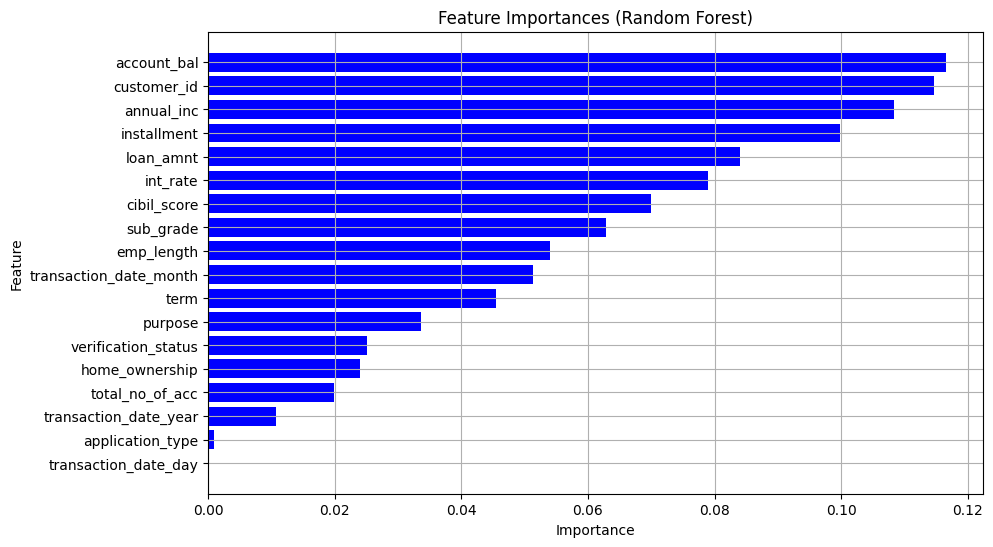

In [ ]:
# Identify categorical columns (e.g., string values)
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)

# Convert categorical columns to numeric using LabelEncoder
label_encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))  # Ensure conversion to string for encoding

# If there are date columns, convert them to numerical values (e.g., year, month, day)
datetime_cols = df.select_dtypes(include=['datetime']).columns
print("Datetime columns:", datetime_cols)

# Convert datetime columns to numerical values (e.g., extract year, month, day)
for col in datetime_cols:
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df.drop(columns=[col], inplace=True)  # Drop the original datetime column

# Drop rows with missing target values
train_df = df.dropna(subset=['loan_status'])

# Ensure X and y have consistent indices
X = df.drop(['loan_status'], axis=1)  # Features
y = df['loan_status']  # Target

# Re-check alignment and shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


# Proceed with splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the transformed (numeric) data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to hold the feature names and their importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by Importance in descending order
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['Feature'], importance_df_sorted['Importance'], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # Invert Y-axis to have the most important features on top
plt.grid()
plt.show()


4. **Model Training & Evaluation**


In model training, the dataset is split into training and testing sets to assess model performance effectively. Hyperparameter tuning is performed using GridSearchCV to optimize model settings, ensuring better accuracy and reliability.

In model evaluation, the trained model's performance is assessed on the test set using multiple metrics, including accuracy, confusion matrix, precision, recall, and F1-score.

deci

In [24]:
# Define the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_dt = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples required to be at a leaf node
}

# Perform GridSearchCV to find the best parameters using 5-fold cross-validation
grid_search_dt = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Get the best Decision Tree classifier with optimal parameters
best_dt_classifier = grid_search_dt.best_estimator_

# Predict on the test set and evaluate performance
y_pred_dt = best_dt_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)

# Print evaluation metrics for the best Decision Tree model
print("Decision Tree Classifier:")
print("Best Parameters:", grid_search_dt.best_params_)
print("Test Accuracy:", accuracy_dt)
print("Test Precision:", precision_dt)
print("Test Recall:", recall_dt)
print("Test ROC AUC:", roc_auc_dt)

# Predict on the test set using the best Decision Tree classifier
y_pred_dt = best_dt_classifier.predict(X_test)

# Calculate the F1 score
f1_dt = f1_score(y_test, y_pred_dt)
print("F1 Score for Decision Tree:", f1_dt)
print(classification_report(y_test, y_pred_dt))


Decision Tree Classifier:
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.7582340266479046
Test Precision: 0.7840020060180541
Test Recall: 0.9292082738944365
Test ROC AUC: 0.6006528102613977
F1 Score for Decision Tree: 0.8504515286693505
              precision    recall  f1-score   support

           0       0.57      0.27      0.37      5917
           1       0.78      0.93      0.85     16824

    accuracy                           0.76     22741
   macro avg       0.68      0.60      0.61     22741
weighted avg       0.73      0.76      0.73     22741



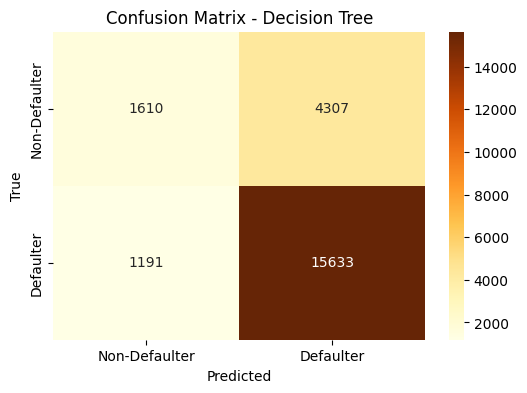

In [27]:
# Compute the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='YlOrBr', xticklabels=['Non-Defaulter', 'Defaulter'], yticklabels=['Non-Defaulter', 'Defaulter'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

log

In [29]:
from sklearn.preprocessing import StandardScaler
# Define the Logistic Regression model
log_reg = LogisticRegression()

# Define the parameter grid for GridSearchCV
param_grid_logreg = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 regularization
}

# Perform GridSearchCV to find the best parameters using 5-fold cross-validation
grid_search_logreg = GridSearchCV(estimator=log_reg, param_grid=param_grid_logreg, scoring='accuracy', cv=5)
grid_search_logreg.fit(X_train, y_train)

# Get the best Logistic Regression model with optimal parameters
best_log_reg = grid_search_logreg.best_estimator_

# Predict on the test set and evaluate performance
y_pred_logreg = best_log_reg.predict(X_test)

# Calculate evaluation metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)

# Print evaluation metrics for the best Logistic Regression model
print("Best Logistic Regression Model:")
print("Best Parameters:", grid_search_logreg.best_params_)
print("Test Accuracy:", accuracy_logreg)
print("Test Precision:", precision_logreg)
print("Test Recall:", recall_logreg)
print("Test ROC AUC:", roc_auc_logreg)

# Scale the selected features consistently
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now, train the Logistic Regression model with the scaled features
best_log_reg.fit(X_train_scaled, y_train)

# Predict on the test set using the Logistic Regression classifier
y_pred_logreg = best_log_reg.predict(X_test_scaled)

# Calculate the F1 score
f1_logreg = f1_score(y_test, y_pred_logreg)
print("F1 Score for Logistic Regression:", f1_logreg)
print(classification_report(y_test, y_pred_dt))


Best Logistic Regression Model:
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.7636867332131393
Test Precision: 0.7815481459624275
Test Recall: 0.944602948169282
Test ROC AUC: 0.5969423393880042
F1 Score for Logistic Regression: 0.8559317457746098
              precision    recall  f1-score   support

           0       0.57      0.27      0.37      5917
           1       0.78      0.93      0.85     16824

    accuracy                           0.76     22741
   macro avg       0.68      0.60      0.61     22741
weighted avg       0.73      0.76      0.73     22741



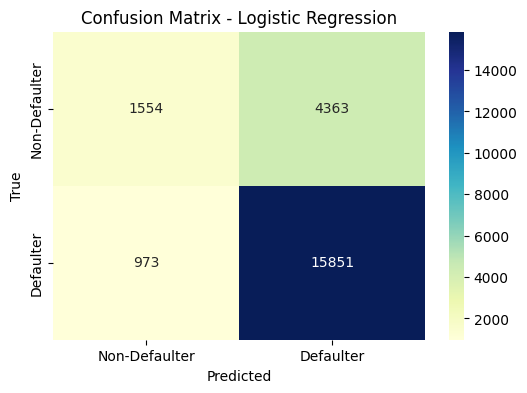

In [30]:
# Compute the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Non-Defaulter', 'Defaulter'], yticklabels=['Non-Defaulter', 'Defaulter'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

naive

In [31]:
# Define the Naive Bayes (GaussianNB) classifier
nb_classifier = GaussianNB()

# Train the classifier on the cleaned training data
nb_classifier.fit(X_train, y_train)

# Predict on the test set and evaluate performance
y_pred_nb = nb_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)

# Print evaluation metrics for Naive Bayes classifier
print("Naive Bayes Classifier:")
print("Test Accuracy:", accuracy_nb)
print("Test Precision:", precision_nb)
print("Test Recall:", recall_nb)
print("Test ROC AUC:", roc_auc_nb)

# Predict on the test set using Naive Bayes classifier
y_pred_nb = nb_classifier.predict(X_test)

# Calculate the F1 score
f1_nb = f1_score(y_test, y_pred_nb)
print("F1 Score for Naive Bayes:", f1_nb)
print(classification_report(y_test, y_pred_dt))


Naive Bayes Classifier:
Test Accuracy: 0.730003078140803
Test Precision: 0.7400898876404495
Test Recall: 0.9787803138373752
Test ROC AUC: 0.5007134626479423
F1 Score for Naive Bayes: 0.8428622613502584
              precision    recall  f1-score   support

           0       0.57      0.27      0.37      5917
           1       0.78      0.93      0.85     16824

    accuracy                           0.76     22741
   macro avg       0.68      0.60      0.61     22741
weighted avg       0.73      0.76      0.73     22741



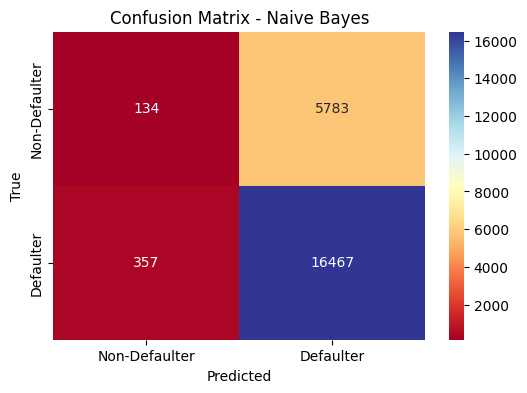

In [32]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)

# Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu', xticklabels=['Non-Defaulter', 'Defaulter'], yticklabels=['Non-Defaulter', 'Defaulter'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

xgboost

In [38]:
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_xgb = {
    'learning_rate': [0.1, 0.01],  # Step size shrinking
    'max_depth': [3, 5, 7],  # Maximum depth of the tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) in a child
    'gamma': [0, 0.1, 0.3],  # Minimum loss reduction required to make a further partition
    'colsample_bytree': [0.5, 0.7]  # Fraction of features to choose when building each tree
}

# Perform GridSearchCV to find the best parameters using 5-fold cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Get the best XGBoost classifier with optimal parameters
best_xgb_classifier = grid_search_xgb.best_estimator_

# Predict on the test set and evaluate performance
y_pred_xgb = best_xgb_classifier.predict(X_test)  # Use selected features for testing

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Print evaluation metrics for the best XGBoost model
print("XGBoost Classifier:")
print("Best Parameters:", grid_search_xgb.best_params_)
print("Test Accuracy:", accuracy_xgb)
print("Test Precision:", precision_xgb)
print("Test Recall:", recall_xgb)
print("Test ROC AUC:", roc_auc_xgb)

# Predict on the test set using the best XGBoost classifier
y_pred_xgb = best_xgb_classifier.predict(X_test)

# Calculate the F1 score
f1_xgb = f1_score(y_test, y_pred_xgb)
print("F1 Score for XGBoost:", f1_xgb)
print(classification_report(y_test, y_pred_dt))


XGBoost Classifier:
Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3}
Test Accuracy: 0.7676883162569808
Test Precision: 0.789030803906837
Test Recall: 0.9363409415121255
Test ROC AUC: 0.6122468608185945
F1 Score for XGBoost: 0.8563972926690043
              precision    recall  f1-score   support

           0       0.57      0.27      0.37      5917
           1       0.78      0.93      0.85     16824

    accuracy                           0.76     22741
   macro avg       0.68      0.60      0.61     22741
weighted avg       0.73      0.76      0.73     22741



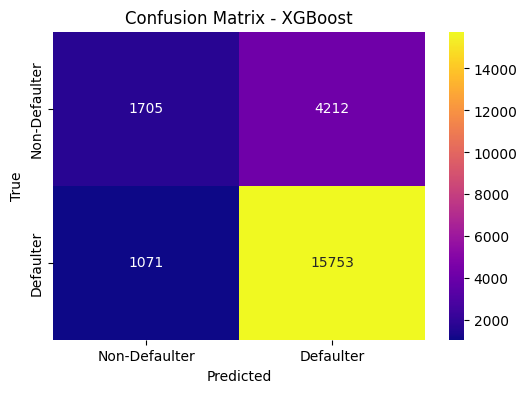

In [39]:
# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)


# Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='plasma', xticklabels=['Non-Defaulter', 'Defaulter'], yticklabels=['Non-Defaulter', 'Defaulter'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

knn

In [40]:
# Define the k-NN classifier
knn_classifier = KNeighborsClassifier()

# Define the parameter grid for GridSearchCV
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Perform GridSearchCV to find the best parameters
grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Get the best k-NN classifier with optimal parameters
best_knn_classifier = grid_search_knn.best_estimator_

# Predict on the test set and evaluate performance
y_pred_knn = best_knn_classifier.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)

# Print evaluation metrics for k-NN classifier
print("k-Nearest Neighbors (k-NN) Classifier:")
print("Best Parameters:", grid_search_knn.best_params_)
print("Test Accuracy:", accuracy_knn)
print("Test Precision:", precision_knn)
print("Test Recall:", recall_knn)
print("Test ROC AUC:", roc_auc_knn)

# Define the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Fit the KNN classifier on the resampled training data
knn_classifier.fit(X_train, y_train)

# Predict on the test set using the KNN classifier
y_pred_knn = knn_classifier.predict(X_test)

# Calculate the F1 score
f1_knn = f1_score(y_test, y_pred_knn)
print("F1 Score for KNN:", f1_knn)
print(classification_report(y_test, y_pred_dt))

k-Nearest Neighbors (k-NN) Classifier:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Test Accuracy: 0.7026076249945034
Test Precision: 0.7459541387571506
Test Recall: 0.9068592486923442
Test ROC AUC: 0.5143557693520873
F1 Score for KNN: 0.8080002185852072
              precision    recall  f1-score   support

           0       0.57      0.27      0.37      5917
           1       0.78      0.93      0.85     16824

    accuracy                           0.76     22741
   macro avg       0.68      0.60      0.61     22741
weighted avg       0.73      0.76      0.73     22741



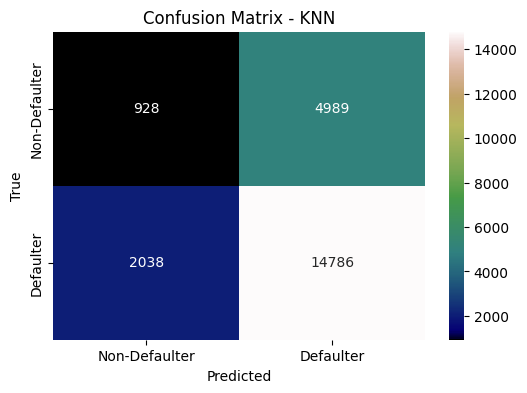

In [41]:
# Compute the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='gist_earth', xticklabels=['Non-Defaulter', 'Defaulter'], yticklabels=['Non-Defaulter', 'Defaulter'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.show()

5. **Model Assessment**

Model assessment using the ROC helps to evaluate the performance of a classification models by visualizing the trade-off between sensitivity and specificity. A higher curve (closer to the top-left corner) indicates better model performance.

The Area Under the Curve (AUC) quantifies this, with a value closer to 1.0 signifying a model that can effectively distinguish between the classes. The ROC curve is a useful tool to assess the robustness and accuracy of the model in classification tasks.

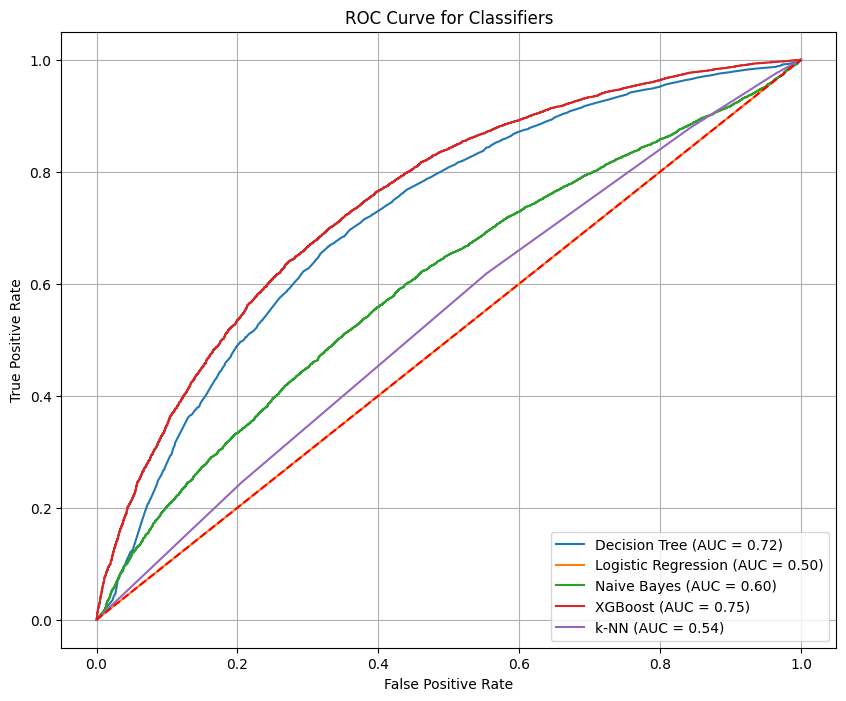

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
# Define a dictionary to store classifiers
classifiers = {
    'Decision Tree': best_dt_classifier,
    'Logistic Regression': best_log_reg,
    'Naive Bayes': nb_classifier,
    'XGBoost': best_xgb_classifier,
    'k-NN': knn_classifier,
}

# Create a figure for ROC curves
plt.figure(figsize=(10, 8))

# Iterate through each classifier and plot its ROC curve
for clf_name, clf in classifiers.items():
    # Make predictions on the test set to obtain probabilities
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:
        # Some classifiers may not have predict_proba (e.g., some Logistic Regression solvers)
        # In that case, we can use decision_function and normalize it to [0, 1]
        y_prob = clf.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalize to [0, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot ROC curve for each classifier
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random guess line)
plt.plot([0, 1], [0, 1], linestyle='--', color='red')

# Add labels and title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

6. **Insights**

  • Decision Tree:
  
  The Decision Tree model demonstrated solid performance with an accuracy of 75.8%, precision of 78.4%, and an impressive recall of 92.9%, indicating its effectiveness in identifying positive cases. However, its ROC AUC of 0.601 suggests moderate ability in distinguishing between classes.
  
  • Logistic Regression:
  
  Logistic Regression showcased balanced and reliable results, achieving an accuracy of 76.4% and an F1 score of 85.6%. Its high recall of 94.5% highlights its strength in minimizing false negatives, making it particularly useful for tasks prioritizing recall. Despite this, its ROC AUC of 0.597 indicates room for improvement in overall class separation.

  • Naive Bayes:
  
  The Naive Bayes model excelled in recall with a remarkable 97.9%, reflecting its ability to correctly capture positive instances. However, its lower precision of 74.0% and ROC AUC of 0.501 indicate struggles with false positives and overall class discrimination.

  • XGBoost:
  
  XGBoost emerged as the top-performing model, delivering the highest accuracy of 76.8% and the best ROC AUC of 0.750. With a precision of 78.9% and recall of 93.6%, it balances precision and recall effectively, making it a robust choice for complex data patterns.

  • KNN:
  
  The k-Nearest Neighbors model provided moderate results, achieving an accuracy of 70.3% and an F1 score of 80.8%. While its recall of 90.7% is commendable, the precision of 74.6% and ROC AUC of 0.514 suggest it may not be as competitive for this dataset compared to other models.




**Conclusion**

  • XGBoost: XGBoost is the best-performing model with a high accuracy of 0.768, the best ROC AUC (0.750), and a strong balance between precision (0.789) and recall (0.936). Its superior performance is due to its ability to capture complex patterns in the data, thanks to its advanced boosting algorithm and hyperparameter tuning.

  • Logistic Regression: Logistic Regression follows closely with an accuracy of 0.764, a high F1 score (0.856), and exceptional recall (0.945). This model is robust and interpretable, making it a reliable choice for tasks emphasizing recall, such as minimizing false negatives in classification problems.